In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import molsysmt as msm
import numpy as np
from simtk import unit
from simtk.openmm import app
import simtk.openmm as mm
from mdtraj.reporters import HDF5Reporter
from sys import stdout
import matplotlib.pyplot as plt

/home/diego/MyMachine/locals/miniconda/envs/OpenExplorer/lib/python3.7/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


no need to add nglview patch


In [3]:
modeller = msm.convert('alanine_dipeptide.pdb', to_form='openmm.Modeller')

topology = modeller.topology
positions = modeller.positions

forcefield = app.ForceField('amber10.xml') # 'amber10_obc.xml')
system = forcefield.createSystem(topology, nonbondedMethod=app.NoCutoff,
                                 implicitSolvent=app.OBC2, soluteDielectric=1.0, solventDielectric=78.5)

NotImplementedConversionError: The conversion from file:pdb to openmm.Modeller has not been implemeted yet. Write a new issue in https://github.com/uibcdf/MolSysMT/issues asking for it.

In [4]:
temperature = 500*unit.kelvin
integration_timestep = 2.0*unit.femtosecond
collision_rate = 1.0/unit.picosecond

integrator = mm.LangevinIntegrator(temperature, collision_rate, integration_timestep)
platform = mm.Platform.getPlatformByName('CUDA')
properties = {'CudaPrecision': 'mixed'}
simulation = app.Simulation(topology, system, integrator, platform, properties)
simulation.context.setPositions(positions)

In [5]:
simulation.minimizeEnergy()

In [6]:
simulation.context.setVelocitiesToTemperature(temperature)

In [7]:
md_time = 1.000 * unit.nanoseconds
saving_time_interval = 1.0 * unit.picoseconds
log_time_interval = 50.0 * unit.picoseconds

In [8]:
md_steps = np.rint(md_time/integration_timestep).astype(int)
saving_steps_interval = np.rint(saving_time_interval/integration_timestep).astype(int)
log_steps_interval = np.rint(log_time_interval/integration_timestep).astype(int)

reporter_log_stdout = app.StateDataReporter(stdout, log_steps_interval, step=True, time=True,
                                            totalEnergy=True, temperature=True,
                                            progress=True, remainingTime=True,
                                            speed=True, totalSteps=md_steps, separator='\t')


reporter_logfile = app.StateDataReporter('traj.log', log_steps_interval, step=True, time=True,
                                            potentialEnergy=True, kineticEnergy=True,
                                            totalEnergy=True, temperature=True,
                                            progress=True, remainingTime=True,
                                            speed=True, totalSteps=md_steps, separator='\t')

reporter_h5file = HDF5Reporter('traj.h5', saving_steps_interval, coordinates=True, time=True,
                               potentialEnergy=True, kineticEnergy=True, temperature=True)

simulation.reporters.append(reporter_log_stdout)
simulation.reporters.append(reporter_logfile)
simulation.reporters.append(reporter_h5file)

simulation.step(md_steps)

reporter_h5file.close()

#"Progress (%)"	"Step"	"Time (ps)"	"Total Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
5.0%	25000	50.00000000001514	158.93553400642497	395.4173867545049	0	--
10.0%	50000	99.99999999994834	147.0518887572772	376.623083109355	4.7e+03	0:16
15.0%	75000	149.99999999998812	189.80430352737793	518.487709543932	4.63e+03	0:15
20.0%	100000	200.00000000022686	152.14011427601895	543.5169470808846	4.49e+03	0:15
25.0%	125000	250.0000000004656	108.3861385844005	391.14377660316455	4.43e+03	0:14
30.0%	150000	300.00000000070435	166.0551324588218	425.8903341739984	4.49e+03	0:13
35.0%	175000	350.0000000009431	182.30230483675888	466.26976693916095	4.51e+03	0:12
40.0%	200000	400.00000000118183	193.26887415153746	558.3890464133697	4.52e+03	0:11
45.0%	225000	450.0000000014206	206.8454713652203	638.3850050990892	4.52e+03	0:10
50.0%	250000	500.0000000016593	180.73150768864926	438.5089945430305	4.49e+03	0:09
55.0%	275000	550.000000000818	235.66598602401905	537.7496772922317	4.51e+03	0:08
6

In [9]:
molecular_system = msm.convert('traj.h5', to_form='molsysmt.MolSys')

/home/diego/Myopt/miniconda3/envs/UIBCDF_lab_dev/lib/python3.7/site-packages/tables/leaf.py:544: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  key = numpy.array(key)


In [10]:
phi_chains, psi_chains, phi_angles, psi_angles = msm.ramachandran_angles(molecular_system)

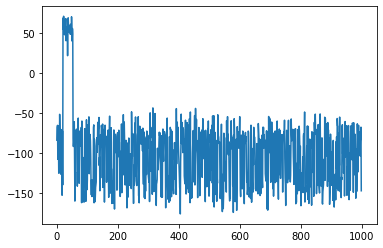

In [11]:
plt.plot(phi_angles)

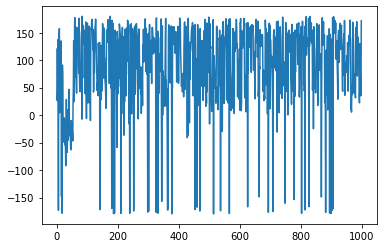

In [12]:
plt.plot(psi_angles)

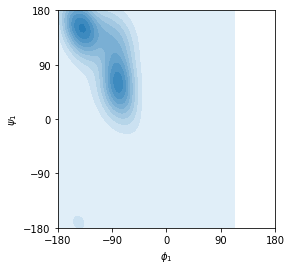

In [13]:
import seaborn as sns

ax = sns.kdeplot(phi_angles[:,0], psi_angles[:,0], shade=True)
ax.set_xlim(-180.0,180.0)
ax.set_ylim(-180.0,180.0)
ax.set_xticks([-180.0, -90.0, 0.0, 90.0, 180.0])
ax.set_yticks([-180.0, -90.0, 0.0, 90.0, 180.0])
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('$\psi_1$')
ax.set_aspect('equal')

In [15]:
bb=msm.least_rmsd(molecular_system)

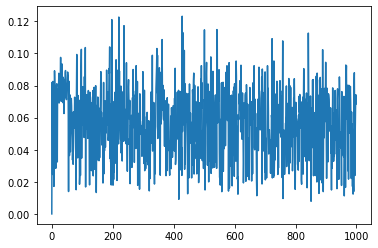

In [16]:
plt.plot(bb)